<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_1_Pytorch_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [82]:
import pandas as pd
from typing import Literal

In [83]:
def dataset_fn(train:Literal["train", "test"]):
  match train:
    case "train":
      df = pd.read_csv("/content/sample_data/california_housing_train.csv")
    case "test":
      df = pd.read_csv("/content/sample_data/california_housing_test.csv")

  return df.drop("median_house_value", axis=1), df["median_house_value"].copy()

In [84]:
x, y = dataset_fn(train="train")
y.head(3)

,median_house_value
0,66900.0
1,80100.0
2,85700.0


In [85]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


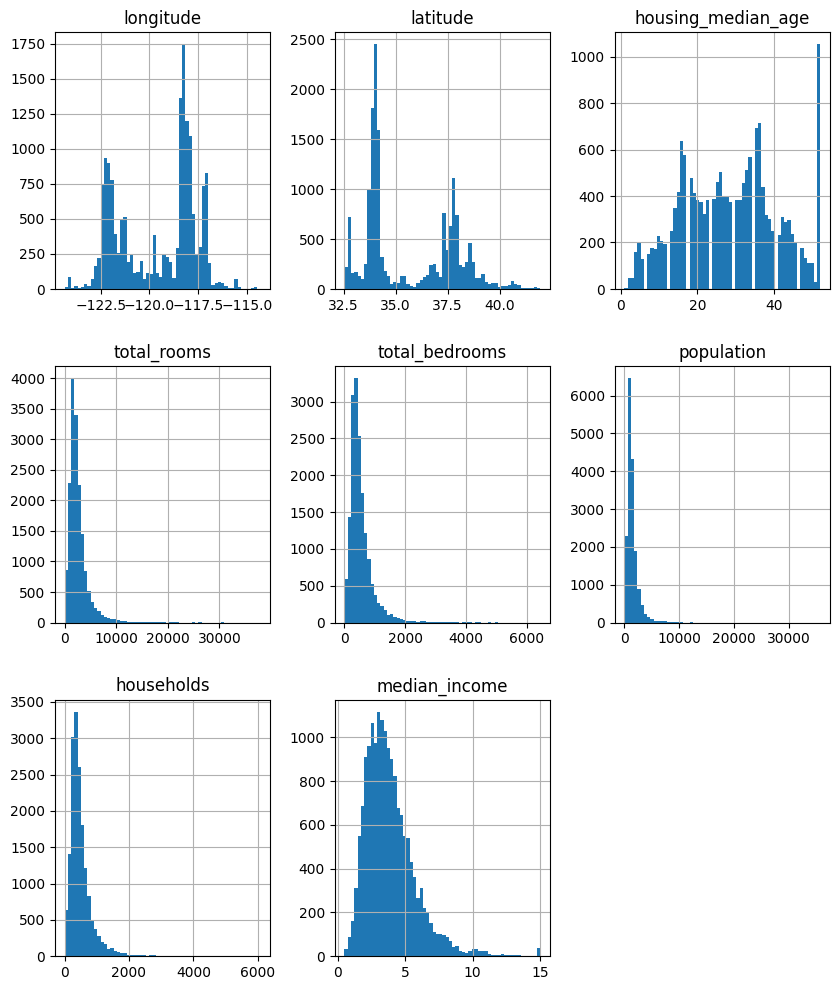

In [86]:
x.hist(figsize=(10, 12), bins=60);

# Dataset

## Splitting into Training and Testing Dataset

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [88]:
x_scaler, y_scaler = StandardScaler(), StandardScaler()

In [89]:
x_scaler.fit(x.to_numpy())
y_scaler.fit(y.to_numpy().reshape(-1, 1))

StandardScaler()

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [91]:
print(f"Training Sample --> {len(x_train)}")
print(f"Testing Sample --> {len(x_test)}")

Training Sample --> 11900
Testing Sample --> 5100


## Dataset and DataLoader

In [92]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [93]:
class CaliforniaDataset(Dataset):
  def __init__(self, x, y, x_scaler=x_scaler, y_scaler=y_scaler):
    self.x = x_scaler.transform(x.to_numpy()).astype(np.float32)
    self.y = y_scaler.transform(y.to_numpy().reshape(-1, 1)).astype(np.float32)
    self.n_samples = len(self.x)

  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return x, y

  def __len__(self):
    return self.n_samples

In [94]:
train_ds = CaliforniaDataset(
    x=x_train,
    y=y_train
    )

In [95]:
test_ds = CaliforniaDataset(
    x=x_test,
    y=y_test
    )

In [96]:
train_dataloader = DataLoader(dataset=train_ds, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=10, shuffle=True)

# Defining Model Architecture

In [97]:
import torch.nn as nn

In [98]:
class CaliforniaModel(nn.Module):
  def __init__(self, skeleton:list):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], 1))
    self.model = nn.Sequential(*layer_list)

  def forward(self, x):
    return self.model(x)

In [99]:
model = CaliforniaModel(skeleton=[8, 300, 200, 100, 50, 20])

In [100]:
lr = 1e-4
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [101]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=30,
    T_mult=1,
    eta_min=1e-6
)

# Training Loop

In [102]:
from tqdm import trange
import numpy as np

In [103]:
def train_step(model, x, y, criterion, optimizer):
  x, y = x.cpu(), y.cpu()

  optimizer.zero_grad()
  y_hat = model(x)
  loss = criterion(y_hat, y)
  loss.backward()
  optimizer.step()
  lr = optimizer.param_groups[0]["lr"]
  return loss.item(), lr

In [104]:
def test_step(model, x, y, criterion):
  x, y = x.cpu(), y.cpu()

  with torch.no_grad():
    y_hat = model(x)
    loss = criterion(y_hat, y)

  return loss.item()

In [105]:
def fit(model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        criterion=criterion, optimizer=optimizer,
        scheduler=scheduler, epochs=30):

  df = pd.DataFrame(np.empty([epochs, 4]),
                    index = np.arange(epochs),
                    columns = ["Training Loss", "Testing Loss", "lr", "Epochs"])

  current_test_loss = float("inf")

  for epoch in range(epochs):

    print(f"Epoch {epoch+1}")
    # Training
    model.train()
    progress_bar = trange(len(train_dataloader), desc="Training")

    train_loss = []

    for batch_idx, (x, y) in enumerate(train_dataloader):
        loss, lr = train_step(model, x, y, criterion, optimizer)
        scheduler.step(epoch + batch_idx / len(train_dataloader))

        progress_bar.set_description("Training Loss=%.9f" % loss)
        progress_bar.set_postfix({"lr": lr})
        progress_bar.update(1)
        train_loss.append(loss)
    progress_bar.close()
    mean_train_loss = np.mean(train_loss)


    # Testing
    model.eval()
    test_losses = []

    progress_bar = trange(len(test_dataloader), desc="Testing")

    for batch_idx, (x, y) in enumerate(test_dataloader):
      loss = test_step(model, x, y, criterion)
      test_losses.append(loss)
      progress_bar.set_description("Testing Loss=%.9f" % loss)
      progress_bar.update(1)

    progress_bar.close()
    mean_test_loss = np.mean(test_losses)

    if mean_test_loss < current_test_loss:
      current_test_loss = mean_test_loss
      print(current_test_loss)
      torch.save(model.state_dict(), "Model_state.pth")
      print("Saving Training State....!!!!!")

    scheduler.step()

    df.iloc[epoch, 0] = mean_train_loss
    df.iloc[epoch, 1] = mean_test_loss
    df.iloc[epoch, 2] = optimizer.param_groups[0]["lr"]
    df.iloc[epoch, 3] = epoch + 1

    print(f"Epoch {epoch+1}: Train Loss={mean_train_loss:.6f}, Test Loss={mean_test_loss:.6f}")

  return df

# Fitting Model

In [106]:
model = model.cpu()

In [107]:
df = fit(model=model)

Epoch 1


Testing Loss=0.166814327: 100%|██████████| 510/510 [00:01<00:00, 344.87it/s]


0.15179788817962012
Saving Training State....!!!!!
Epoch 1: Train Loss=0.208357, Test Loss=0.151798
Epoch 2


Testing Loss=0.118153296: 100%|██████████| 510/510 [00:01<00:00, 354.63it/s]


Epoch 2: Train Loss=0.184873, Test Loss=0.181867
Epoch 3


Testing Loss=0.089306474: 100%|██████████| 510/510 [00:01<00:00, 331.61it/s]


Epoch 3: Train Loss=0.175561, Test Loss=0.170512
Epoch 4


Testing Loss=0.238020033: 100%|██████████| 510/510 [00:01<00:00, 358.91it/s]


0.14045384896955654
Saving Training State....!!!!!
Epoch 4: Train Loss=0.173489, Test Loss=0.140454
Epoch 5


Testing Loss=0.335645914: 100%|██████████| 510/510 [00:01<00:00, 368.83it/s]


Epoch 5: Train Loss=0.167166, Test Loss=0.142421
Epoch 6


Testing Loss=0.104120396: 100%|██████████| 510/510 [00:01<00:00, 368.41it/s]


Epoch 6: Train Loss=0.165002, Test Loss=0.151150
Epoch 7


Testing Loss=0.162509710: 100%|██████████| 510/510 [00:01<00:00, 381.58it/s]


Epoch 7: Train Loss=0.163640, Test Loss=0.145729
Epoch 8


Testing Loss=0.102070712: 100%|██████████| 510/510 [00:01<00:00, 365.58it/s]


0.13309684430121207
Saving Training State....!!!!!
Epoch 8: Train Loss=0.161281, Test Loss=0.133097
Epoch 9


Testing Loss=0.079164833: 100%|██████████| 510/510 [00:01<00:00, 337.97it/s]


0.13247081882082948
Saving Training State....!!!!!
Epoch 9: Train Loss=0.159105, Test Loss=0.132471
Epoch 10


Testing Loss=0.122284509: 100%|██████████| 510/510 [00:01<00:00, 340.42it/s]


0.1267092498932399
Saving Training State....!!!!!
Epoch 10: Train Loss=0.157535, Test Loss=0.126709
Epoch 11


Testing Loss=0.066094115: 100%|██████████| 510/510 [00:01<00:00, 320.63it/s]


Epoch 11: Train Loss=0.150672, Test Loss=0.134011
Epoch 12


Testing Loss=0.039312132: 100%|██████████| 510/510 [00:01<00:00, 350.85it/s]


Epoch 12: Train Loss=0.153617, Test Loss=0.149115
Epoch 13


Testing Loss=0.105923116: 100%|██████████| 510/510 [00:01<00:00, 363.73it/s]


Epoch 13: Train Loss=0.157511, Test Loss=0.154723
Epoch 14


Testing Loss=0.226836562: 100%|██████████| 510/510 [00:01<00:00, 356.89it/s]


Epoch 14: Train Loss=0.152657, Test Loss=0.142326
Epoch 15


Testing Loss=0.047266059: 100%|██████████| 510/510 [00:01<00:00, 352.44it/s]


Epoch 15: Train Loss=0.148090, Test Loss=0.128698
Epoch 16


Testing Loss=0.055772521: 100%|██████████| 510/510 [00:01<00:00, 343.04it/s]


Epoch 16: Train Loss=0.150386, Test Loss=0.131012
Epoch 17


Testing Loss=0.046293698: 100%|██████████| 510/510 [00:01<00:00, 353.36it/s]


Epoch 17: Train Loss=0.148872, Test Loss=0.144051
Epoch 18


Testing Loss=0.157599315: 100%|██████████| 510/510 [00:01<00:00, 309.93it/s]


Epoch 18: Train Loss=0.147102, Test Loss=0.131271
Epoch 19


Testing Loss=0.172997952: 100%|██████████| 510/510 [00:01<00:00, 379.66it/s]


Epoch 19: Train Loss=0.142685, Test Loss=0.137022
Epoch 20


Testing Loss=0.221851990: 100%|██████████| 510/510 [00:01<00:00, 360.15it/s]


0.126649181146686
Saving Training State....!!!!!
Epoch 20: Train Loss=0.143242, Test Loss=0.126649
Epoch 21


Testing Loss=0.054857321: 100%|██████████| 510/510 [00:01<00:00, 349.63it/s]


Epoch 21: Train Loss=0.143732, Test Loss=0.129442
Epoch 22


Testing Loss=0.189928979: 100%|██████████| 510/510 [00:01<00:00, 350.22it/s]


0.1252209193292348
Saving Training State....!!!!!
Epoch 22: Train Loss=0.143818, Test Loss=0.125221
Epoch 23


Testing Loss=0.039305072: 100%|██████████| 510/510 [00:01<00:00, 347.22it/s]


Epoch 23: Train Loss=0.144209, Test Loss=0.136333
Epoch 24


Testing Loss=0.103063025: 100%|██████████| 510/510 [00:01<00:00, 351.59it/s]


Epoch 24: Train Loss=0.142902, Test Loss=0.131073
Epoch 25


Testing Loss=0.083877675: 100%|██████████| 510/510 [00:01<00:00, 369.73it/s]


Epoch 25: Train Loss=0.143010, Test Loss=0.129941
Epoch 26


Testing Loss=0.050402679: 100%|██████████| 510/510 [00:01<00:00, 336.81it/s]


Epoch 26: Train Loss=0.141318, Test Loss=0.138171
Epoch 27


Testing Loss=0.205619007: 100%|██████████| 510/510 [00:01<00:00, 334.68it/s]


0.12200098743516148
Saving Training State....!!!!!
Epoch 27: Train Loss=0.142286, Test Loss=0.122001
Epoch 28


Testing Loss=0.194087714: 100%|██████████| 510/510 [00:01<00:00, 355.28it/s]


Epoch 28: Train Loss=0.139833, Test Loss=0.125523
Epoch 29


Testing Loss=0.057649594: 100%|██████████| 510/510 [00:01<00:00, 349.76it/s]


0.11999715474233323
Saving Training State....!!!!!
Epoch 29: Train Loss=0.141892, Test Loss=0.119997
Epoch 30


Testing Loss=0.092091218: 100%|██████████| 510/510 [00:01<00:00, 305.22it/s]

Epoch 30: Train Loss=0.141855, Test Loss=0.125281


## Model Training Inferences

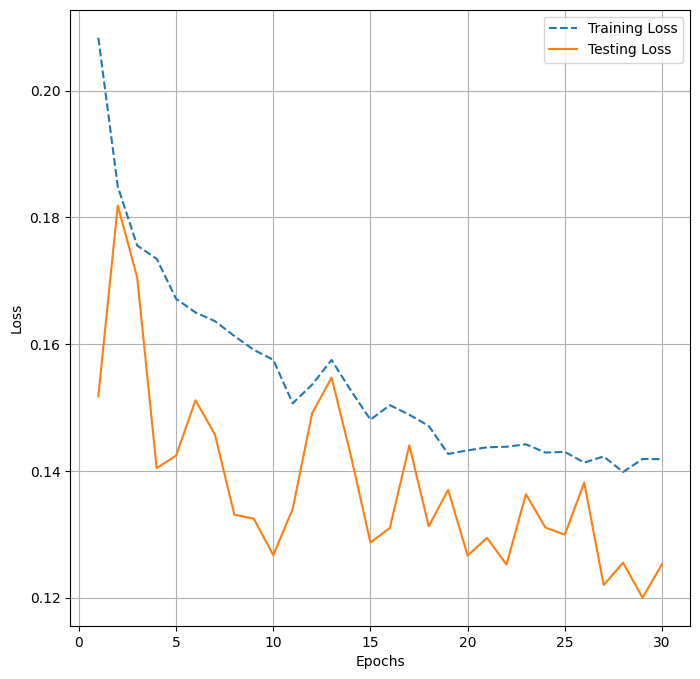

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(df["Epochs"],df["Training Loss"], "--", markersize=3, label="Training Loss")
plt.plot(df["Epochs"],df["Testing Loss"], label="Testing Loss")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Model Inference

In [109]:
def test_model(state_dict_path, criterion):
  x,y = dataset_fn(train="test")
  ds = CaliforniaDataset(x, y)
  dataloader = DataLoader(ds, batch_size=10, shuffle=False)

  test_losses = []

  model.load_state_dict(state_dict=torch.load(state_dict_path))
  print("Model Loaded....")

  model.eval()
  progress_bar = trange(len(dataloader), desc="Model Eval")

  for batch, (x,y) in enumerate(dataloader):
    loss = test_step(model, x, y, criterion)
    test_losses.append(loss)
    progress_bar.set_description("Testing Loss=%.9f" % loss)
    progress_bar.update(1)

  progress_bar.close()
  mean_test_loss = np.mean(test_losses)

  return mean_test_loss

In [110]:
mean_loss = test_model(state_dict_path="/content/Model_state.pth", criterion=nn.MSELoss())
corrected_mean_loss = y_scaler.inverse_transform(mean_loss.reshape(-1, 1))

RMSE = np.sqrt(corrected_mean_loss)

Model Loaded....


Testing Loss=0.247269005: 100%|██████████| 300/300 [00:00<00:00, 316.96it/s]


In [111]:
print(f"The final Root Mean Square Loss is ${RMSE[0, 0]}")

The final Root Mean Square Loss is $487.5016602417576
